In [92]:
import numpy as np
import pandas as pd
import math
import joblib
import os

In [51]:
import custom_transformers
from importlib import reload
reload(custom_transformers)

<module 'custom_transformers' from 'C:\\Users\\giaco\\OneDrive\\ABM Data\\DATA ANALYSIS\\custom_transformers.py'>

In [52]:
from custom_transformers import (
    TransformAdoptionFeatures,
    TransformCensusFeatures, 
    TransformClimateFeatures,
    TransformSoilFeatures,
    TransformEconomicFeatures,
)

In [99]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [93]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [54]:
 # How to display floats
pd.options.display.float_format = '{:.6f}'.format
np.set_printoptions(precision=10)

# Data ingestion

In [55]:
path_to_dataset = "Municipalities final dataset for analysis.csv"

In [56]:
dataset_original = pd.read_csv(path_to_dataset, index_col=['Municipality', 'Year'])

In [57]:
# Remove outliers adoption_in_year
outliers = dataset_original.loc[dataset_original['adoption_in_year'] > 0.1].index
dataset_original = dataset_original.drop(outliers)
print(outliers)

MultiIndex([( 'Abrantes', 2010),
            ( 'Abrantes', 2012),
            ('Alcochete', 2010),
            ('Alcochete', 2011),
            ('Alcochete', 2012),
            (    'Tomar', 2005),
            ('Vila Flor', 2009)],
           names=['Municipality', 'Year'])


In [58]:
# Remove outliers cumul_adoption_10_y_pr_y_munic
outliers = dataset_original.loc[dataset_original['tot_cumul_adoption_pr_y_munic'] > 0.39].index
dataset_original = dataset_original.drop(outliers)
print(outliers)

MultiIndex([('Abrantes', 2011),
            (   'Tomar', 2004),
            (   'Tomar', 2006),
            (   'Tomar', 2007),
            (   'Tomar', 2008),
            (   'Tomar', 2009),
            (   'Tomar', 2010),
            (   'Tomar', 2011),
            (   'Tomar', 2012)],
           names=['Municipality', 'Year'])


In [59]:
# Remove outliers cumul_adoption_10_y_pr_y_munic
outliers = dataset_original.loc[dataset_original['adoption_pr_y_munic'] > 0.1].index
dataset_original = dataset_original.drop(outliers)
print(outliers)

MultiIndex([('Vila Flor', 2010)],
           names=['Municipality', 'Year'])


In [60]:
dataset_original['adoption_in_year'] = dataset_original['adoption_in_year'].apply(lambda x: 1 if x > 0.0000001 else 0)

In [61]:
dataset_original.shape

(4386, 86)

In [62]:
dataset = dataset_original.reset_index(drop=True)

### Remove features regarding adoption not used and not available in the ABM

In [63]:
feats = dataset.columns.to_list()
#feats_tot_cumul = [feat for feat in feats if "tot_cumul" in feat]
feats_neigh_km = [feat for feat in feats if "km" in feat]

#feats_to_remove = list(set(feats_tot_cumul + feats_neigh_km))
feats_to_remove = feats_neigh_km

In [64]:
dataset.drop(feats_to_remove, axis=1, inplace=True)
dataset.shape

(4386, 71)

## Copy the data splitting label and features

In [65]:
dataset_labels = dataset['adoption_in_year'].copy()
dataset = dataset.drop('adoption_in_year', axis=1)

In [66]:
dataset_labels.describe()

count   4386.000000
mean       0.512084
std        0.499911
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: adoption_in_year, dtype: float64

# Features preparation

## Features names collection

In [67]:
features_original = [feat for feat in dataset.columns]

In [68]:
features_adoption = [feat for feat in features_original if 'adoption' in feat]
features_climate = [feat for feat in features_original if '_t_' in feat or '_prec_' in feat]
features_soil = ['CaCO3_mean_munic', 'CN_mean_munic', 'N_mean_munic', 'P_mean_munic', 'pH_mean_munic']

features_not_census = (features_adoption + features_climate + features_soil + features_economic)
features_census = [feat for feat in features_original if feat not in features_not_census]

In [69]:
len(features_census) + len(features_not_census)

70

### Post-transformation

In [70]:
# Get features names
feat_lists = [features_adoption, features_census, features_climate, features_soil, features_economic]
transformers = [TransformAdoptionFeatures(), TransformCensusFeatures(),
                TransformClimateFeatures(), TransformSoilFeatures()]

features = []
for f, t in zip(feat_lists, transformers):
    features_ind = t.transform(dataset[f]).columns.to_list()
    features = features + features_ind

In [71]:
len(features)

24

## Preparation pipeline

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [73]:
transformation_pipeline = ColumnTransformer([
    ('adoption', TransformAdoptionFeatures(), features_adoption),
    ('census', TransformCensusFeatures(), features_census),
    ('climate', TransformClimateFeatures(), features_climate),
    ('soil', TransformSoilFeatures(), features_soil)
],
    remainder='drop')

In [74]:
dataset_prepared = transformation_pipeline.fit_transform(dataset)

In [75]:
dataset_prep = pd.DataFrame(dataset_prepared, columns=features)

In [76]:
dataset_prep.shape

(4386, 24)

# Models analysis

In [77]:
from sklearn.base import clone
from sklearn.model_selection import train_test_split
import shap
from pdpbox import pdp, get_dataset, info_plots

In [78]:
# Create dictionary to be able to get the index of the feature
features_idx = {}
for i, f in enumerate(features):
    features_idx[f] = i

### Stratified split

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
years = dataset_original.index.get_level_values(1).to_list()
train_X, val_X, train_y, val_y = train_test_split(dataset_prep, dataset_labels, stratify=years, random_state=42)

## Classifier: 

In [81]:
ml_model = joblib.load('./Models to analyse/classifiers/nl_svm.pkl')
model = Pipeline([
    ('scaling', StandardScaler()),
    ('estimator', ml_model)
])

In [82]:
model.fit(train_X, train_y)

Pipeline(steps=[('scaling', StandardScaler()),
                ('estimator',
                 SVC(C=8.500403195472156, degree=2, gamma=0.05331982703880401,
                     probability=True))])

### Partial dependence plots

In [83]:
def plot_pdps(model, feats_to_plot):
    if type(feats_to_plot) == str:
        pdp_goals = pdp.pdp_isolate(model=model, dataset=val_X, model_features=features, feature=feats_to_plot)
        pdp.pdp_plot(pdp_goals, feat_to_plot, figsize=(10, 7), plot_pts_dist=True)
    else:
        for feat in feats_to_plot:
            pdp_goals = pdp.pdp_isolate(model=model, dataset=val_X, model_features=features, feature=feat)
            pdp.pdp_plot(pdp_goals, feat, figsize=(10, 7), plot_pts_dist=True)[1]

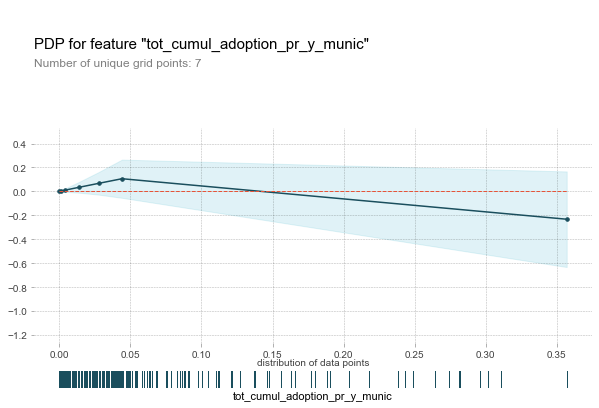

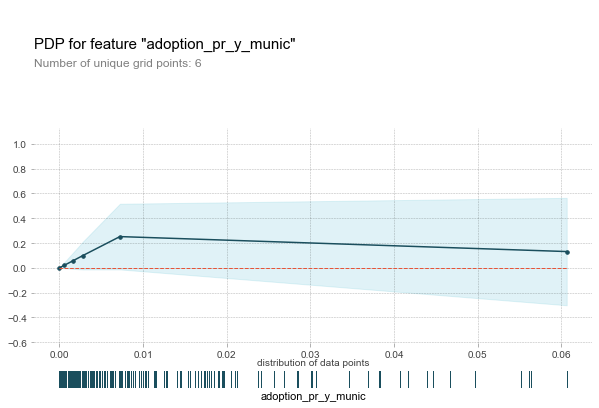

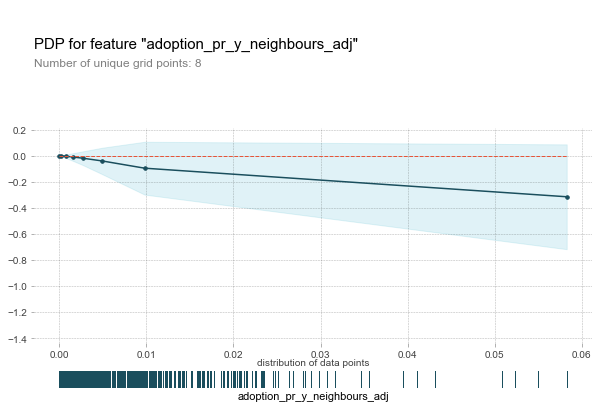

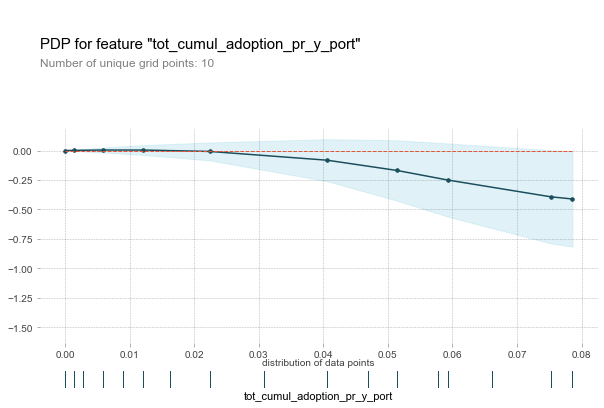

In [85]:
feats_to_plot = ['tot_cumul_adoption_pr_y_munic', 'adoption_pr_y_munic',
                 'adoption_pr_y_neighbours_adj', 'tot_cumul_adoption_pr_y_port']
plot_pdps(model, feats_to_plot)

### Permutation importance

In [130]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(val_X, val_y)

In [131]:
eli5.show_weights(perm, feature_names = features)

Weight,Feature
0.1026 ± 0.0184,tot_cumul_adoption_pr_y_port
0.0649 ± 0.0148,av_d_max_t_average_munic
0.0594 ± 0.0029,adoption_pr_y_munic
0.0518 ± 0.0099,av_d_mean_t_average_munic
0.0507 ± 0.0099,CN_mean_munic
0.0463 ± 0.0104,adoption_pr_y_port
0.0445 ± 0.0113,prof_above_some_long
0.0394 ± 0.0059,econ_2_4
0.0387 ± 0.0131,educ_3rd_cycle_or_higher
0.0379 ± 0.0167,cons_days_no_prec_average_munic


### SHAP values

In [86]:
#explainer = shap.KernelExplainer(model.predict, shap.sample(train_X, 5))
explainer = shap.KernelExplainer(model.predict, shap.kmeans(train_X, 50))

In [87]:
# Calculate shap_values for all of val_X
shap_values = explainer.shap_values(val_X)

Saving figure shap_classifier


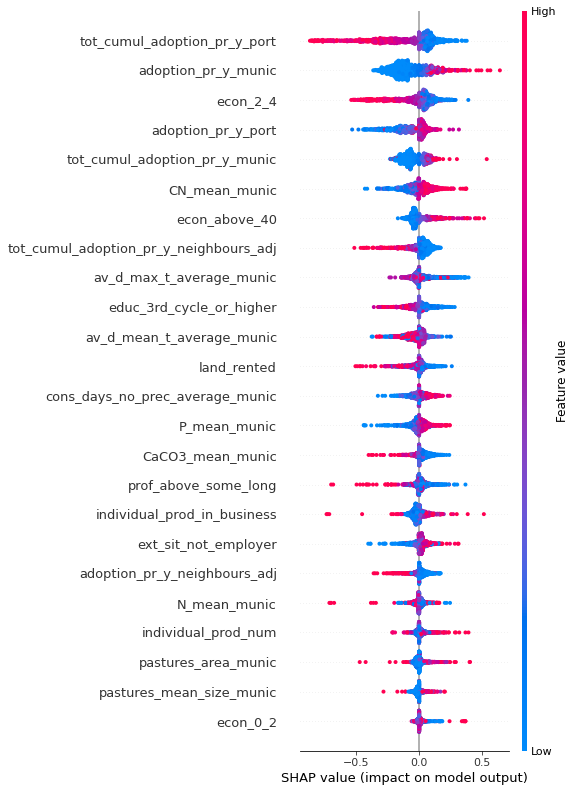

In [101]:
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, val_X, feature_names=features, max_display=len(features), show=False)
fig = plt.gcf()
save_fig(('shap_classifier'), tight_layout=True)

TypeError: gcf() got an unexpected keyword argument 'figsize'

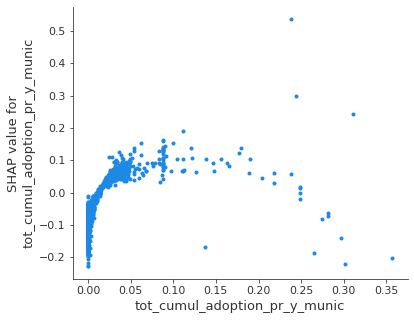

In [115]:
feat_to_plot = 'tot_cumul_adoption_pr_y_munic'
feat_interact = None
shap.dependence_plot(features_idx[feat_to_plot], shap_values, val_X, feature_names=features,
                     interaction_index=feat_interact, show=False)
fig = plt.gcf()
save_fig(('cumul_munic_classifier'), tight_layout=True)

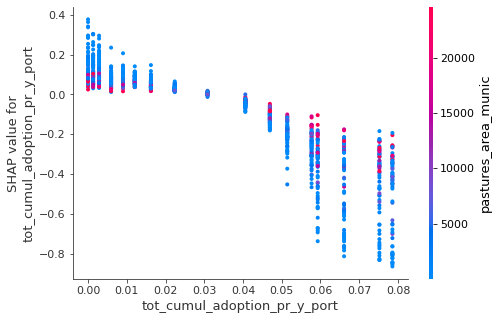

In [110]:
feat_to_plot = 'tot_cumul_adoption_pr_y_port'
feat_interact = 'auto'
shap.dependence_plot(features_idx[feat_to_plot], shap_values, val_X, feature_names=features,
                     interaction_index=feat_interact)

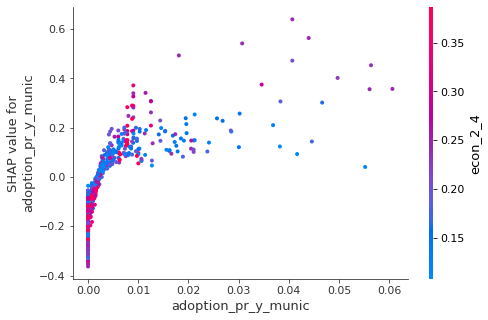

In [107]:
feat_to_plot = 'adoption_pr_y_munic'
feat_interact = 'econ_2_4'
shap.dependence_plot(features_idx[feat_to_plot], shap_values, val_X, feature_names=features,
                     interaction_index=feat_interact)